# Toy Example

First be sure the notebook is running with GPU.

Runtime -> Change Runtime Type -> GPU

In [1]:
# Colab only
# download and install Pytorch
%pip install torch torchvision
%pip install numpy matplotlib

In [2]:
# import the packages
import numpy as np
from PIL import Image
from IPython.display import clear_output
import matplotlib.pyplot as plt

# import PyTorch (Deep Learning lib)
import torch
import torch.nn as nn
import torch.nn.functional as F

import math


In [3]:

from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)


Mounted at /content/gdrive


In [ ]:
# load the image, convert it as an array of float, and divide to have [0,1] values
# path to the image on the drive
image_filename = "/content/gdrive/My Drive/foulard1-bis.jpg"

im = np.array(Image.open(image_filename), dtype=float)/255

FileNotFoundError: [Errno 2] No such file or directory: '/content/gdrive/My Drive/foulard1-bis.jpg'

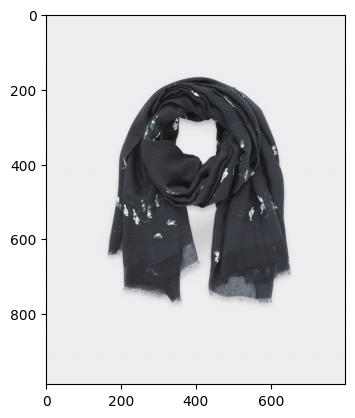

In [ ]:
# display the original images
plt.figure()
plt.imshow(im)
plt.show()

In [ ]:
# convert to torch with batch dimension as first dimension
image = torch.from_numpy(im.transpose(2,0,1)).float().unsqueeze(0)
print(image.shape)


torch.Size([1, 3, 988, 800])


## Neural network creation

The neural network is a Python class, it must inherit from the ```torch.nn.Module``` class of Pytorch.

It is composed of two main methods:
* ```__init__```, the contructor which define the layers to be used. The layers contain the paramters to be optimized
* ```forward```,  the method that define the links between the layers

As an example, we create a network based on UNet, a semantic segmeentation network.
This network has an encoder / decoder strcuture with skip connection.

To do Super Resolution, we simply use add a last block with one dimension augmentation (```upconv0```).

In [ ]:
# create the neural network with Pytorch
class Mynet(nn.Module):
  """Unet segmentation network."""

  def __init__(self, in_channels, out_channels):
    """Init Unet fields."""
    super(Mynet, self).__init__()

    self.in_channels = in_channels

    self.conv = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
    self.bn = nn.BatchNorm2d(64)

    self.conv2 = nn.Conv2d(64, out_channels, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(3)


  def forward(self, x):
    """Forward method."""

    x = F.relu(self.bn(self.conv(x)))
    x = F.relu(self.bn2(self.conv2(x)))

    return x

In [ ]:
# actual network creation
net = Mynet(3,3)
net.cuda() # go GPU

image = image.cuda() # go gpu for the image data


## Optimization

There are two steps.
First we create the optimizer and then, we loop over the dataset (here, only one image) 1000 times and optimize the network weights.

In [ ]:
# create the optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-5)

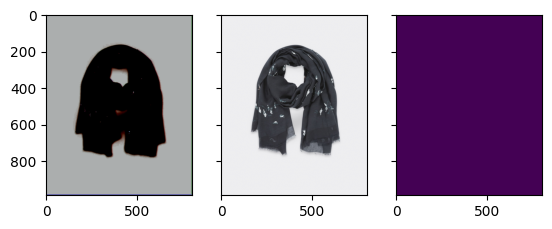

518.77099609375
518.7700805664062
518.7691650390625
518.7682495117188
518.7672729492188
518.766357421875
518.7654418945312
518.7645874023438
518.763671875
518.7627563476562
518.7617797851562
518.7609252929688
518.7600708007812
518.759033203125
518.7582397460938
518.7572631835938
518.7564086914062
518.7554321289062
518.7545776367188
518.7537231445312
518.7527465820312
518.7518920898438
518.7509765625
518.75
518.7491455078125
518.748291015625
518.747314453125
518.7465209960938
518.7455444335938
518.7446899414062
518.7438354492188
518.742919921875
518.7420654296875
518.7411499023438
518.7401733398438
518.7393188476562
518.7383422851562
518.7376098632812
518.7366943359375
518.7357788085938
518.7349243164062
518.7340698242188
518.733154296875
518.7322387695312
518.7314453125
518.73046875
518.7296752929688
518.728759765625
518.7279052734375
518.72705078125
518.7261962890625
518.7252807617188
518.7244262695312
518.7234497070312
518.7227172851562
518.7217407226562
518.7210083007812
518.7200927

KeyboardInterrupt: 

In [ ]:
# Epoch loops (the number of times we see the training dataset)
for i in range(1000):

  for j in range(1): # iterate over the dataset (here one single image, should be more)

    # forward pass, compute the output of the network




    outputs = net(image)

    # compute the error (here mean square error)
    loss = F.mse_loss(outputs, image)

    # reinitialize the gradients
    optimizer.zero_grad()

    # compute the gradients
    loss.backward()

    # update the weights
    optimizer.step()

    print(loss.item())

  # display the results
  if i%100 == 0:
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
    clear_output(wait=True)
    outputs_np = outputs.cpu().detach().numpy()[0].transpose(1,2,0)
    ax1.imshow(np.clip(outputs_np,0,1))
    ax2.imshow(im)
    ax3.imshow(((outputs_np-im)**2).sum(axis=2))
    plt.show()
